In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

### 0. Idea
The idea of this exercise is to compute the price of a <b>barrier option</b> using Monte Carlo Simulation. Barrier options come in two varieties:
- <b>Knock-in</b>: only having a payoff if the barrier level is reached before expiry
- <b>Knock-out</b>: only having a payoff if the barrier is not reached before expiry

Note that:
- If the barrier is above the initial asset value, we have an <b>up option</b>
- If the barrier is below the initial asset value, we have an <b>down option</b>

### 1. Define Parameter

In [2]:
T = 5
r = 0.05
sigma = 0.2
S_0 = 100
K1 = 100                    # 1nd strike price for digital option
K2 = 180                    # 2nd strike price for digital option
barrier = 200               # Barrier for the Up-and-Out feature

no_of_paths = 1000
no_of_steps = 250

We are going to price a <b>Up-and-Out Barrier Option</b> with a <b>digial payoff</b>: $$ max(S-K_{1}, 0) - max(S-K_{2}, 0)$$

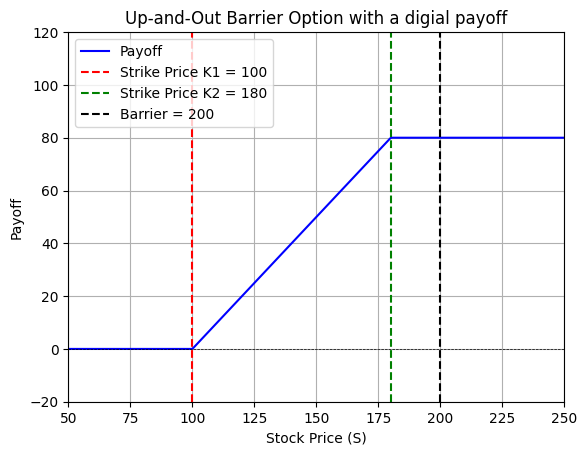

In [3]:
S = np.linspace(50, 250, 400)

# Calculate the payoff
payoff = np.maximum(S - K1, 0) - np.maximum(S - K2, 0)

# Plotting the payoff
plt.figure()
plt.plot(S, payoff, label='Payoff', color='blue')
plt.title('Up-and-Out Barrier Option with a digial payoff')
plt.xlabel('Stock Price (S)')
plt.ylabel('Payoff')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(K1, color='red', linestyle='--', label='Strike Price K1 = 100')
plt.axvline(K2, color='green', linestyle='--', label='Strike Price K2 = 180')
plt.axvline(200, color='black', linestyle='--', label='Barrier = 200')
plt.legend()
plt.grid()
plt.xlim(50, 250)
plt.ylim(-20, 120)
plt.show()

### 2. Up-and-Out Digital Option Pricing

First, we would <b>simulate multiple paths of stock price</b> using Euler Discretication. Assuming stock prices follow <b>Geometric Brownian Motion under Risk-Neutral Measure</b>

$$dS(t) = rS(t)dt + \sigma S(t)dW^{Q}(t)$$

In [4]:
def generate_paths_GMB_Euler(no_of_paths, no_of_steps, T, r, sigma, S_0):
    Z = np.random.normal(0.0, 1.0, [no_of_paths, no_of_steps])
    W = np.zeros([no_of_paths, no_of_steps+1])
    S = np.zeros([no_of_paths, no_of_steps+1])
    S[:,0] = S_0
    time = np.zeros([no_of_steps+1])

    dt = T / float(no_of_steps)
    for i in range(0, no_of_steps):
        ## Making sure random numbers generated follow Standard Normal Distribution by normalizing them
        Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])

        # Euler Discretization
        W[:,i+1] = W[:,i] + np.sqrt(dt) * Z[:,i]
        S[:,i+1] = S[:,i] + r * S[:,i] * dt + sigma * S[:,i] * (W[:,i+1] - W[:,i])
        time[i+1] = time[i] + dt

    paths = {'time': time, 'S': S}
    return paths    

paths = generate_paths_GMB_Euler(no_of_paths, no_of_steps, T, r, sigma, S_0)

Text(0.5, 1.0, 'Simulation of Stock Price S(t)')

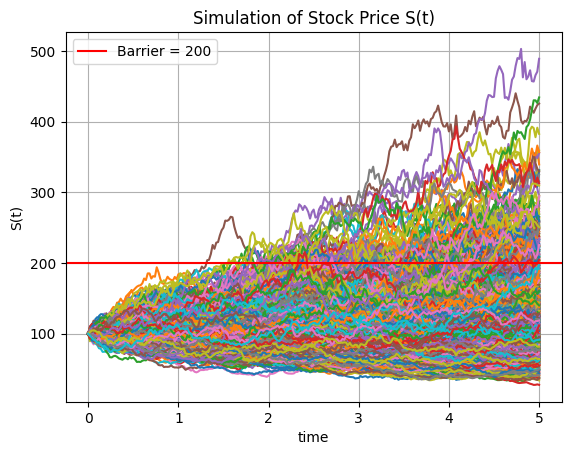

In [5]:
plt.figure(1)
plt.plot(paths['time'], np.transpose(paths['S']))
plt.grid()
plt.xlabel("time")
plt.ylabel("S(t)")
plt.axhline(y = 200, color = 'r', linestyle = '-', label='Barrier = 200')
plt.legend()
plt.title("Simulation of Stock Price S(t)")

Now, under <b>Risk-Neutral Pricing</b>, the price V(t) of the derivative security at time t is given by:

$$ V(t) = \tilde{\mathbb{E}} \left[ e^{- \int_t^T r(u) \, du} V(T) \mid \mathcal{F}(t) \right]$$

where we take the <b>conditional expectation under Risk-Neutral Measure of the discounted payoff at maturity</b>. Notice that <b>payoff at maturity equals to zero</b> if the barrier is reached at any time for the corresponding path

In [6]:
payoff = lambda S, K1, K2: np.maximum(S-K1, 0) - np.maximum(S-K2, 0)

def price_UpAndOutCall_MC(S, K1, K2, barrier, T, r, payoff):

    n1, n2 = S.shape
    barrier_matrix = np.zeros([n1,n2]) + barrier

    hit_barrier = S > barrier
    hit_barrier = np.sum(hit_barrier, 1)
    path_not_out = (hit_barrier == 0)
    
    return np.exp(-r * T) * np.mean(payoff(S[:,-1]*path_not_out, K1, K2))


In [7]:
price_UpAndOutCall = price_UpAndOutCall_MC(paths['S'], K1, K2, barrier, T, r, payoff)
print(f'The call price of Up and Out Option from Monte Carlo Simulation is {price_UpAndOutCall}')

The call price of Up and Out Option from Monte Carlo Simulation is 11.557915013326658
